In [18]:
%load_ext autoreload
%autoreload 2
import load_prism
import load_tether
import torch
import yaml
import logging
from imp import reload
import matplotlib.pyplot as plt
from liftpose.vision_3d import *
from liftpose.preprocess import concat_dict, total_frames, center_poses, anchor_to_root, flatten_dict, unflatten_dict
from liftpose.plot import plot_pose_3d, plot_pose_2d
reload(logging)
logger = logging.getLogger(__name__).setLevel(logging.INFO)
from tqdm import tqdm
tqdm.get_lock().locks = []

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load data in the source domain (tethered fly) and rotate it to ventral camera angle

In [19]:
# declare data parameters
par_train = {  'data_dir'       : '/data/LiftPose3D/fly_tether/data_DF3D_prism', # change the path 
              #'data_dir'       : r'\Users\NeLy\Desktop\fly_tether', #windows path format
               'out_dir'        : '/data/LiftPose3D/domain_adaptation/test',
               'train_subjects' : ['Fly1','Fly2','Fly3','Fly4','Fly5','Fly6','Fly7'],
               'test_subjects'  : ['Fly8','Fly9'],
               'actions'        : ['all']}


intr = intrinsic_matrix(171.0 * 94.0, 171.0 * 94.0, 240, 480) 

training_kwargs = {'eangles': {0: [[0,0], [0, 0], [-2,2]]},
                   'axsorder': 'xzy',
                   'vis': None,
                   'tvec': {0: np.array([0, 0, 117])},
                   'intr': {0: intr},
                   'norm_2d': False}

# merge with training parameters
par_data = yaml.full_load(open('param.yaml', "rb"))
par = {**par_data["data"], **par_train}

# Load 3D data
train_3d_source = load_tether.load_3D(
    par["data_dir"],
    par,
    subjects=par["train_subjects"],
    actions=par["actions"],
)

test_3d_source = load_tether.load_3D(
    par["data_dir"],
    par,
    subjects=par["test_subjects"],
    actions=par["actions"],
)

#roots are bit wobbly across frames so stabilize them by anchoring and then adding the root for frame #1
#train_3d_source = flatten_dict(train_3d_source)
#train_3d_source, offset = anchor_to_root(train_3d_source, par['roots'], par['target_sets'], 3)
#k0 = None
#for k in train_3d_source.keys():
#    if k0 is None:
#        k0=k
#    train_3d_source[k] += offset[k0][0,:]

#train_3d_source = unflatten_dict(train_3d_source,3)

train_3d_source = center_poses(train_3d_source)
test_3d_source = center_poses(test_3d_source)

#project to ventral view
train_3d_source = process_dict(project_to_eangle, train_3d_source, 1, [-90,0,0], axsorder='xzy')
test_2d_source = process_dict(project_to_eangle, 
                              test_3d_source, 
                              1, 
                              [-90,0,0], 
                              axsorder='xzy', 
                              project=True, 
                              tvec=training_kwargs['tvec'][0], 
                              intr=training_kwargs['intr'][0])
test_3d_source = process_dict(project_to_eangle, test_3d_source, 1, [-90,0,0], axsorder='xzy')

# Train network

In [20]:
from liftpose.preprocess import obtain_projected_stats
    
stats = obtain_projected_stats(train_3d_source,
                               training_kwargs['eangles'], 
                               training_kwargs['axsorder'], 
                               training_kwargs['vis'],
                               training_kwargs['tvec'],
                               training_kwargs['intr'],
                               par['roots'], 
                               par['target_sets'],
                               par['out_dir'],
                               load_existing=True,
                               th=1,
                               norm_2d=False)

[preprocess.py:413]:INFO:Bootstrapping mean and variance...
[preprocess.py:417]:INFO:Loaded existing data.


In [21]:
from liftpose.main import train as lp3d_train
from liftpose.lifter.augmentation import random_project

aug = random_project(**training_kwargs)

lp3d_train(train_2d=None, test_2d=test_2d_source,
           train_3d=train_3d_source, test_3d=test_3d_source, 
           #train_keypts=train_keypts,
           #test_keypts=test_keypts,
           roots=par['roots'],
           target_sets=par['target_sets'],
           out_dir=par['out_dir'],
           training_kwargs={"epochs":30},
           augmentation=[aug],
           stats=stats,
           norm_2d=False
          )

[main.py:241]:INFO:Saving pre-processed 2D data at /data/LiftPose3D/domain_adaptation/test/stat_2d.pth.tar.
[main.py:260]:INFO:Saving pre-processed 3D data at /data/LiftPose3D/domain_adaptation/test/stat_3d.pth.tar.
[main.py:288]:INFO:Starting training model.
[main.py:299]:DEBUG:
==================Options=================
[main.py:300]:DEBUG:{   'batch_size': 64,
    'data_dir': '/data/LiftPose3D/domain_adaptation/test',
    'drop_input': 0.0,
    'dropout': 0.5,
    'epochs': 30,
    'exp': '',
    'is_train': True,
    'job': 8,
    'linear_size': 1024,
    'load': None,
    'lr': 0.001,
    'lr_decay': 5000,
    'lr_gamma': 0.9,
    'max_norm': True,
    'noise': None,
    'num_stage': 2,
    'out': '/data/LiftPose3D/domain_adaptation/test',
    'out_dir': '/data/LiftPose3D/domain_adaptation/test',
    'predict': False,
    'procrustes': False,
    'resume': False,
    'test': False}
[main.py:301]:DEBUG:==========================================

[lift.py:29]:INFO:Training on the de

Epoch 000 | LR  0.00100 | Loss Test  0.00000 | Loss Train  6.58962|:   0%|          | 6/1280 [00:00<01:19, 15.97it/s]


KeyboardInterrupt: 

# Plot results to check if network is correctly trained

[pyplot.py:289]:DEBUG:Loaded backend module://ipykernel.pylab.backend_inline version unknown.


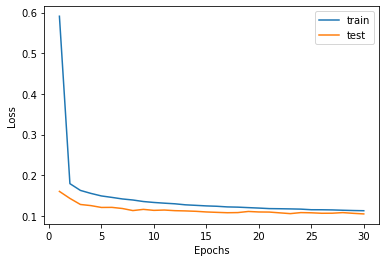

In [23]:
%matplotlib inline
from liftpose.plot import read_log_train, plot_log_train
epoch, lr, loss_train, loss_test, err_test = read_log_train(par['out_dir'])
plot_log_train(plt.gca(), loss_train, loss_test, epoch)

In [24]:
from liftpose.main import test as lp3d_test
lp3d_test(par['out_dir'])

[main.py:388]:INFO:starting testing in path: /data/LiftPose3D/domain_adaptation/test
[lift.py:29]:INFO:Training on the device: cuda:0
[lift.py:56]:INFO:total params: 4.33M
[lift.py:64]:INFO:loading ckpt from '/data/LiftPose3D/domain_adaptation/test/ckpt_best.pth.tar'
[lift.py:72]:INFO:ckpt loaded (epoch: 29 | err: 0.0435903278757361)
[lift.py:106]:INFO:Saving results: /data/LiftPose3D/domain_adaptation/test/test_results.pth.tar


In [28]:
from liftpose.postprocess import load_test_results
gt, pred, good_keypts = load_test_results(par['out_dir'])

[pyplot.py:289]:DEBUG:Loaded backend module://ipykernel.pylab.backend_inline version unknown.


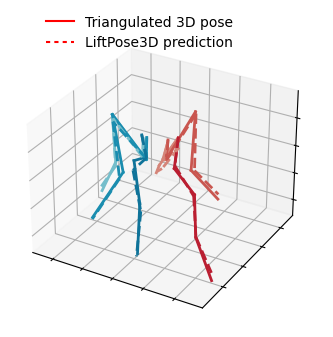

In [29]:
# https://stackoverflow.com/a/38865534/7554774
# conda install ipympl
#%matplotlib widget
%matplotlib inline
from liftpose.plot import plot_pose_3d
from scipy.spatial.transform import Rotation as Rot

t = 1000

fig = plt.figure(figsize=plt.figaspect(1), dpi=100)
ax = fig.add_subplot(111, projection='3d')

plot_pose_3d(ax, tar=gt[t],
            pred=pred[t],
            bones=par_data["vis"]["bones"], 
            limb_id=par_data["vis"]["limb_id"], 
            colors=par_data["vis"]["colors"],
            legend=True,
            normalize=False)

# Errors

[pyplot.py:289]:DEBUG:Loaded backend module://ipykernel.pylab.backend_inline version unknown.
[utils.py:145]:INFO:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
[utils.py:157]:INFO:NumExpr defaulting to 8 threads.
[_base.py:2646]:DEBUG:top of axes not in the figure, so title not moved
[_base.py:2646]:DEBUG:top of axes not in the figure, so title not moved
[_base.py:2646]:DEBUG:top of axes not in the figure, so title not moved
[_base.py:2646]:DEBUG:top of axes not in the figure, so title not moved
[_base.py:2646]:DEBUG:top of axes not in the figure, so title not moved
[_base.py:2646]:DEBUG:top of axes not in the figure, so title not moved
[_base.py:2646]:DEBUG:top of axes not in the figure, so title not moved


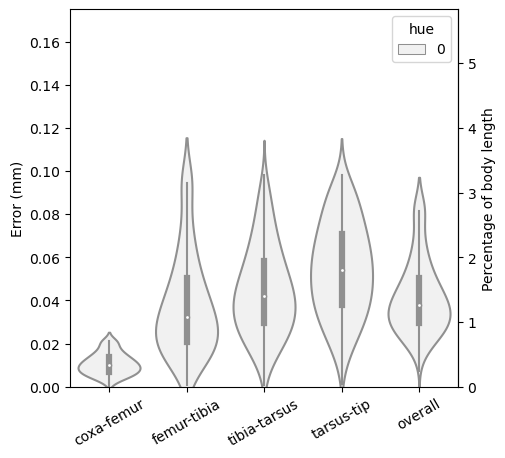

In [32]:
%matplotlib inline
from liftpose.plot import violin_plot
import random, string
plt.figure(figsize=(5,5), dpi=100)
names = ['coxa-femur','femur-tibia','tibia-tarsus','tarsus-tip']
ax = plt.gca()
s = gt.shape
gt_reshape = gt.reshape(s[0]*6, s[1]//6, 3)[:,1:,:]
pred_reshape = pred.reshape(s[0]*6, s[1]//6, 3)[:,1:,:]
kp_reshape = good_keypts.reshape(s[0]*6, s[1]//6, 3)[:,1:,:]
violin_plot(ax, gt=gt_reshape, pred=pred_reshape, good_keypts=kp_reshape,
                name=names, order=names, units='mm', body_length=3)
ax.set_ylim([0,0.175])
plt.savefig('errors.svg')